In [ ]:
import subprocess
import time
import json
import matplotlib.pyplot as plt

# Precio del KWh (puedes ajustarlo a lo que pagas en tu zona, por ejemplo 0.20 euros)
price_per_kwh = 0.20  # en euros o dólares

# Definir el intervalo de monitoreo (en segundos)
monitoring_interval = 30  # medio minuto

# Definir el archivo donde se guardarán los datos de uso de la GPU
gpu_usage_file = './experiment_results/gpu_usage.json'
gpu_data = []

# Función para obtener el uso de la GPU con nvidia-smi
def get_gpu_usage():
    try:
        # Ejecutar nvidia-smi y obtener el uso de VRAM y potencia en Watts
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,power.draw', '--format=csv,nounits,noheader'], stdout=subprocess.PIPE)
        output = result.stdout.decode('utf-8').strip()
        vram_usage, power_draw = output.split(', ')
        
        return {
            "vram_usage_mb": int(vram_usage),
            "power_draw_watts": float(power_draw),
            "timestamp": time.time()
        }
    except Exception as e:
        print(f"Error obteniendo el uso de la GPU: {e}")
        return None

# Función para generar gráficos
def generate_gpu_usage_graph(gpu_data):
    timestamps = [entry["timestamp"] for entry in gpu_data]
    vram_usages = [entry["vram_usage_mb"] for entry in gpu_data]
    power_draws = [entry["power_draw_watts"] for entry in gpu_data]

    # Convertir timestamps a tiempo relativo en minutos
    time_relative = [(t - timestamps[0]) / 60 for t in timestamps]

    # Crear gráfica de uso de VRAM
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(time_relative, vram_usages, label='VRAM Usage (MB)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('VRAM Usage (MB)')
    plt.title('VRAM Usage Over Time')
    plt.grid(True)

    # Crear gráfica de consumo de potencia
    plt.subplot(1, 2, 2)
    plt.plot(time_relative, power_draws, label='Power Draw (W)', color='orange')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Power Draw (W)')
    plt.title('Power Draw Over Time')
    plt.grid(True)

    # Guardar la gráfica en un archivo
    plt.tight_layout()
    plt.savefig('./experiment_results/gpu_usage_graph.png')
    plt.show()

# Función para calcular el coste total del entrenamiento
def calculate_training_cost(gpu_data, price_per_kwh):
    total_energy_kwh = 0.0
    
    for i in range(1, len(gpu_data)):
        # Tiempo transcurrido entre mediciones en horas
        time_diff_hours = (gpu_data[i]["timestamp"] - gpu_data[i-1]["timestamp"]) / 3600
        # Energía consumida entre mediciones en kWh
        energy_kwh = (gpu_data[i]["power_draw_watts"] * time_diff_hours) / 1000
        total_energy_kwh += energy_kwh

    # Calcular el coste total
    total_cost = total_energy_kwh * price_per_kwh
    return total_cost

# Iniciar el monitoreo
try:
    while True:
        # Obtener el uso de la GPU
        gpu_usage = get_gpu_usage()
        
        if gpu_usage:
            print(f"VRAM Usage: {gpu_usage['vram_usage_mb']} MB, Power Draw: {gpu_usage['power_draw_watts']} W")
            
            # Guardar los datos en la lista
            gpu_data.append(gpu_usage)
            
            # Guardar los datos en el archivo JSON
            with open(gpu_usage_file, 'w') as f:
                json.dump(gpu_data, f, indent=4)
        
        # Esperar hasta la siguiente medición
        time.sleep(monitoring_interval)

except KeyboardInterrupt:
    print("Monitoreo finalizado.")
    
    # Generar gráficos al finalizar el monitoreo
    generate_gpu_usage_graph(gpu_data)

    # Calcular y mostrar el coste total del entrenamiento
    total_cost = calculate_training_cost(gpu_data, price_per_kwh)
    print(f"Coste total del entrenamiento: {total_cost:.2f} euros")


VRAM Usage: 1151 MB, Power Draw: 32.97 W
VRAM Usage: 7679 MB, Power Draw: 148.05 W
VRAM Usage: 7729 MB, Power Draw: 146.06 W
VRAM Usage: 7753 MB, Power Draw: 126.17 W
VRAM Usage: 7819 MB, Power Draw: 147.65 W
VRAM Usage: 7779 MB, Power Draw: 144.12 W
VRAM Usage: 7780 MB, Power Draw: 134.98 W
VRAM Usage: 7779 MB, Power Draw: 135.99 W
VRAM Usage: 7779 MB, Power Draw: 127.57 W
VRAM Usage: 7779 MB, Power Draw: 142.23 W
VRAM Usage: 7779 MB, Power Draw: 133.59 W
VRAM Usage: 7778 MB, Power Draw: 114.21 W
VRAM Usage: 7822 MB, Power Draw: 125.9 W
VRAM Usage: 7823 MB, Power Draw: 148.9 W
VRAM Usage: 7823 MB, Power Draw: 142.08 W
VRAM Usage: 7823 MB, Power Draw: 146.33 W
VRAM Usage: 7825 MB, Power Draw: 144.08 W
VRAM Usage: 7825 MB, Power Draw: 110.93 W
VRAM Usage: 7823 MB, Power Draw: 146.6 W
VRAM Usage: 7826 MB, Power Draw: 110.65 W
VRAM Usage: 7826 MB, Power Draw: 117.66 W
VRAM Usage: 7826 MB, Power Draw: 129.28 W
VRAM Usage: 7826 MB, Power Draw: 121.22 W
VRAM Usage: 7824 MB, Power Draw: 139.6

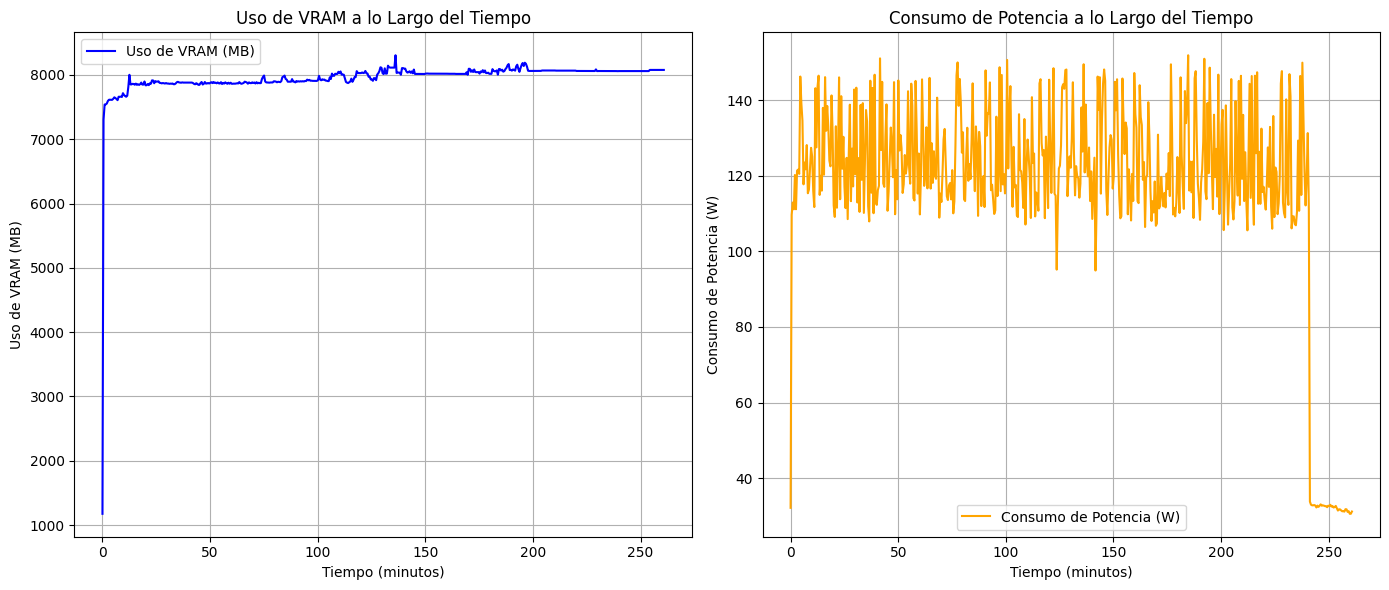

Coste total del entrenamiento: 0.10 euros


In [2]:
import json
import matplotlib.pyplot as plt
import time

# Precio del KWh (ajusta según tu zona)
price_per_kwh = 0.20  # en euros

# Archivo donde se guardaron los datos de uso de la GPU
gpu_usage_file = './experiment_results/gpu_usage.json'

# Función para generar gráficos
def generate_gpu_usage_graph(gpu_data):
    if not gpu_data:
        print("No hay datos para graficar.")
        return
    
    timestamps = [entry["timestamp"] for entry in gpu_data]
    vram_usages = [entry["vram_usage_mb"] for entry in gpu_data]
    power_draws = [entry["power_draw_watts"] for entry in gpu_data]

    # Convertir timestamps a tiempo relativo en minutos
    time_relative = [(t - timestamps[0]) / 60 for t in timestamps]

    # Crear gráfica de uso de VRAM
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(time_relative, vram_usages, label='Uso de VRAM (MB)', color='blue')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Uso de VRAM (MB)')
    plt.title('Uso de VRAM a lo Largo del Tiempo')
    plt.grid(True)
    plt.legend()

    # Crear gráfica de consumo de potencia
    plt.subplot(1, 2, 2)
    plt.plot(time_relative, power_draws, label='Consumo de Potencia (W)', color='orange')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Consumo de Potencia (W)')
    plt.title('Consumo de Potencia a lo Largo del Tiempo')
    plt.grid(True)
    plt.legend()

    # Guardar la gráfica en un archivo
    plt.tight_layout()
    plt.savefig('./experiment_results/gpu_usage_graph.png')
    plt.show()

# Función para calcular el coste total del entrenamiento
def calculate_training_cost(gpu_data, price_per_kwh):
    if len(gpu_data) < 2:
        print("No hay suficientes datos para calcular el coste.")
        return 0.0
    
    total_energy_kwh = 0.0
    
    for i in range(1, len(gpu_data)):
        # Tiempo transcurrido entre mediciones en horas
        time_diff_hours = (gpu_data[i]["timestamp"] - gpu_data[i-1]["timestamp"]) / 3600
        # Energía consumida entre mediciones en kWh
        energy_kwh = (gpu_data[i]["power_draw_watts"] * time_diff_hours) / 1000
        total_energy_kwh += energy_kwh

    # Calcular el coste total
    total_cost = total_energy_kwh * price_per_kwh
    return total_cost

# Leer los datos desde el archivo JSON
def load_gpu_data(file_path):
    try:
        with open(file_path, 'r') as f:
            gpu_data = json.load(f)
            return gpu_data
    except FileNotFoundError:
        print(f"El archivo {file_path} no existe.")
        return []
    except json.JSONDecodeError:
        print(f"Error al decodificar el archivo JSON {file_path}.")
        return []

# Ejecutar las funciones
gpu_data = load_gpu_data(gpu_usage_file)

if gpu_data:
    # Generar los gráficos
    generate_gpu_usage_graph(gpu_data)

    # Calcular y mostrar el coste total del entrenamiento
    total_cost = calculate_training_cost(gpu_data, price_per_kwh)
    print(f"Coste total del entrenamiento: {total_cost:.2f} euros")
else:
    print("No se encontraron datos para procesar.")
